In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 128

train_data = datasets.CIFAR10(root='./data', train=True,
                              download=True, transform=transform)
train_dataloader = DataLoader(train_data, batch_size=batch_size,
                              shuffle=True, num_workers=2)

test_data = datasets.CIFAR10(root='./data', train=False,
                             download=True, transform=transform)
test_dataloader = DataLoader(test_data, batch_size=batch_size,
                             shuffle=False, num_workers=2)

# plane, car, bird, cat, deer, dog, frog, horse, ship, truck

100%|██████████| 170M/170M [00:13<00:00, 12.5MB/s]


0 torch.Size([128, 3, 32, 32]) torch.Size([128])


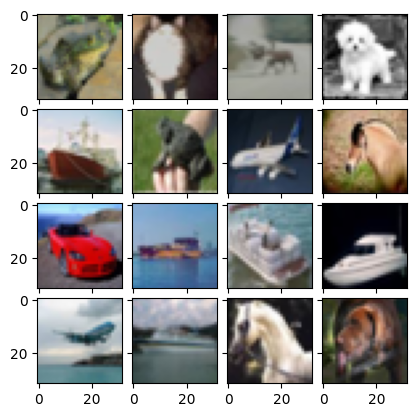

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

# get batch from dataloader
sampler = enumerate(train_dataloader)
batch_idx, (x, y) = next(sampler)
print(batch_idx, x.shape, y.shape)

# select sample images
images = [x[i].squeeze().permute(1, 2, 0).numpy()/2 + 0.5 for i in range(16)]

# create and display plot
fig = plt.figure()
grid = ImageGrid(fig, 111,
                 nrows_ncols=(4, 4),
                 axes_pad=0.1,
)
for axis, image in zip(grid, images):
    # Iterating over the grid returns the Axes.
    axis.imshow(image)

plt.show()

In [3]:
import torch.nn as nn

# create model
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_1 = nn.Conv2d(in_channels=3, out_channels=8,
                                kernel_size=3, stride=1, padding=1)

        self.conv_2 = nn.Conv2d(in_channels=8, out_channels=16,
                                kernel_size=3, stride=1, padding=1)

        self.conv_3 = nn.Conv2d(in_channels=16, out_channels=32,
                                kernel_size=3, stride=1, padding=1)

        self.conv_4 = nn.Conv2d(in_channels=32, out_channels=64,
                                kernel_size=3, stride=1, padding=1)

        self.pool = nn.MaxPool2d(2, 2)

        self.linear_1 = nn.Linear(256, 64)
        self.linear_2 = nn.Linear(64, 10)

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv_1(x)
        x = self.relu(x)
        x = self.pool(x)

        x = self.conv_2(x)
        x = self.relu(x)
        x = self.pool(x)

        x = self.conv_3(x)
        x = self.relu(x)
        x = self.pool(x)

        x = self.conv_4(x)
        x = self.relu(x)
        x = self.pool(x)

        x = torch.flatten(x, start_dim=1, end_dim=-1)

        x = self.linear_1(x)
        x = self.relu(x)
        x = self.linear_2(x)

        return x

In [4]:
# define the training and test steps
def train(model, ce_loss, optimizer, dataloader):
  model.train()
  losses = []
  accuracies = []
  for batch_idx, (x, y) in enumerate(dataloader):
    x, y = x.to('cuda'), y.to('cuda')
    optimizer.zero_grad()

    pred = model(x)
    loss = ce_loss(pred, y)
    loss.backward()
    optimizer.step()

    accuracy = torch.mean((torch.argmax(pred, dim=-1) == y).float())

    losses.append(loss.detach().cpu())
    accuracies.append(accuracy.cpu())

  return torch.mean(torch.stack(losses, dim=0)), torch.mean(torch.stack(accuracies, dim=0))

def test(model, ce_loss, dataloader):
  model.eval()
  losses = []
  accuracies = []
  for batch_idx, (x, y) in enumerate(dataloader):
    x, y = x.to('cuda'), y.to('cuda')

    pred = model(x)
    loss = ce_loss(pred, y)

    accuracy = torch.mean((torch.argmax(pred, dim=-1) == y).float())

    losses.append(loss.detach().cpu())
    accuracies.append(accuracy.cpu())

  return torch.mean(torch.stack(losses, dim=0)), torch.mean(torch.stack(accuracies, dim=0))

In [ ]:
import torch.optim as optim

# hyperparameters
num_epochs = 30
lr = 1e-2
momentum = 0.9
weight_decay = 1e-4

# create model, optimizer, and loss function
model = CNN().to('cuda')
optimizer = optim.SGD(model.parameters(), lr=lr,
                      weight_decay=weight_decay, momentum=momentum)
ce_loss = nn.CrossEntropyLoss() # <- Softmax + CE

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []
for epoch in range(num_epochs):
  train_loss, train_accuracy = train(model, ce_loss, optimizer, train_dataloader)
  test_loss, test_accuracy = test(model, ce_loss, test_dataloader)

  print(f'[{epoch}] Train loss: {train_loss.item():.2f}, Train Accuracy: {train_accuracy.item():.2f}, Test loss: {test_loss.item():.2f}, Test Accuracy: {test_accuracy.item():.2f}')

  train_losses.append(train_loss.item())
  test_losses.append(test_loss.item())
  train_accuracies.append(train_accuracy.item())
  test_accuracies.append(test_accuracy.item())

[0] Train loss: 2.22, Train Accuracy: 0.17, Test loss: 1.94, Test Accuracy: 0.24
[1] Train loss: 1.71, Train Accuracy: 0.37, Test loss: 1.58, Test Accuracy: 0.42
[2] Train loss: 1.46, Train Accuracy: 0.47, Test loss: 1.35, Test Accuracy: 0.51
[3] Train loss: 1.30, Train Accuracy: 0.53, Test loss: 1.22, Test Accuracy: 0.56
[4] Train loss: 1.18, Train Accuracy: 0.58, Test loss: 1.15, Test Accuracy: 0.59
[5] Train loss: 1.08, Train Accuracy: 0.62, Test loss: 1.08, Test Accuracy: 0.62
[6] Train loss: 1.01, Train Accuracy: 0.64, Test loss: 1.04, Test Accuracy: 0.62
[7] Train loss: 0.95, Train Accuracy: 0.66, Test loss: 0.99, Test Accuracy: 0.65
[8] Train loss: 0.90, Train Accuracy: 0.68, Test loss: 1.00, Test Accuracy: 0.65
[9] Train loss: 0.85, Train Accuracy: 0.70, Test loss: 0.99, Test Accuracy: 0.65
[10] Train loss: 0.82, Train Accuracy: 0.71, Test loss: 0.96, Test Accuracy: 0.66
[11] Train loss: 0.79, Train Accuracy: 0.72, Test loss: 1.05, Test Accuracy: 0.65
[12] Train loss: 0.75, Tra

In [ ]:
import torch.nn as nn

# create model
class CNNBatchNorm(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_1 = nn.Conv2d(in_channels=3, out_channels=8,
                                kernel_size=3, stride=1, padding=1)
        self.bn_1 = nn.BatchNorm2d(8)

        self.conv_2 = nn.Conv2d(in_channels=8, out_channels=16,
                                kernel_size=3, stride=1, padding=1)
        self.bn_2 = nn.BatchNorm2d(16)

        self.conv_3 = nn.Conv2d(in_channels=16, out_channels=32,
                                kernel_size=3, stride=1, padding=1)
        self.bn_3 = nn.BatchNorm2d(32)

        self.conv_4 = nn.Conv2d(in_channels=32, out_channels=64,
                                kernel_size=3, stride=1, padding=1)
        self.bn_4 = nn.BatchNorm2d(64)

        self.pool = nn.MaxPool2d(2, 2)

        self.linear_1 = nn.Linear(256, 64)
        self.bn_linear = nn.BatchNorm1d(64)
        self.linear_2 = nn.Linear(64, 10)

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv_1(x)
        x = self.bn_1(x)
        x = self.relu(x)
        x = self.pool(x)

        x = self.conv_2(x)
        x = self.bn_2(x)
        x = self.relu(x)
        x = self.pool(x)

        x = self.conv_3(x)
        x = self.bn_3(x)
        x = self.relu(x)
        x = self.pool(x)

        x = self.conv_4(x)
        x = self.bn_4(x)
        x = self.relu(x)
        x = self.pool(x)

        x = torch.flatten(x, start_dim=1, end_dim=-1)

        x = self.linear_1(x)
        x = self.bn_linear(x)
        x = self.relu(x)
        x = self.linear_2(x)

        return x

In [ ]:
# hyperparameters
num_epochs = 30
lr = 1e-2
momentum = 0.9
weight_decay = 1e-4

# create model, optimizer, and loss function
model = CNNBatchNorm().to('cuda')
optimizer = optim.SGD(model.parameters(), lr=lr,
                      weight_decay=weight_decay, momentum=momentum)
ce_loss = nn.CrossEntropyLoss()

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []
for epoch in range(num_epochs):
  train_loss, train_accuracy = train(model, ce_loss, optimizer, train_dataloader)
  test_loss, test_accuracy = test(model, ce_loss, test_dataloader)

  print(f'[{epoch}] Train loss: {train_loss.item():.2f}, Train Accuracy: {train_accuracy.item():.2f}, Test loss: {test_loss.item():.2f}, Test Accuracy: {test_accuracy.item():.2f}')

  train_losses.append(train_loss.item())
  test_losses.append(test_loss.item())
  train_accuracies.append(train_accuracy.item())
  test_accuracies.append(test_accuracy.item())

[0] Train loss: 1.39, Train Accuracy: 0.50, Test loss: 1.16, Test Accuracy: 0.59
[1] Train loss: 1.03, Train Accuracy: 0.63, Test loss: 1.03, Test Accuracy: 0.63
[2] Train loss: 0.89, Train Accuracy: 0.69, Test loss: 1.05, Test Accuracy: 0.64
[3] Train loss: 0.80, Train Accuracy: 0.72, Test loss: 0.97, Test Accuracy: 0.66
[4] Train loss: 0.74, Train Accuracy: 0.74, Test loss: 0.86, Test Accuracy: 0.70
[5] Train loss: 0.69, Train Accuracy: 0.76, Test loss: 0.99, Test Accuracy: 0.66
[6] Train loss: 0.65, Train Accuracy: 0.77, Test loss: 0.85, Test Accuracy: 0.71
[7] Train loss: 0.61, Train Accuracy: 0.78, Test loss: 0.81, Test Accuracy: 0.72
[8] Train loss: 0.58, Train Accuracy: 0.79, Test loss: 0.82, Test Accuracy: 0.72
[9] Train loss: 0.56, Train Accuracy: 0.80, Test loss: 0.82, Test Accuracy: 0.72
[10] Train loss: 0.53, Train Accuracy: 0.81, Test loss: 0.82, Test Accuracy: 0.72
[11] Train loss: 0.51, Train Accuracy: 0.82, Test loss: 0.89, Test Accuracy: 0.71
[12] Train loss: 0.49, Tra

In [ ]:
import torch.nn as nn

# create model
class CNNDropout(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_1 = nn.Conv2d(in_channels=3, out_channels=8,
                                kernel_size=3, stride=1, padding=1)
        self.bn_1 = nn.BatchNorm2d(8)

        self.conv_2 = nn.Conv2d(in_channels=8, out_channels=16,
                                kernel_size=3, stride=1, padding=1)
        self.bn_2 = nn.BatchNorm2d(16)

        self.conv_3 = nn.Conv2d(in_channels=16, out_channels=32,
                                kernel_size=3, stride=1, padding=1)
        self.bn_3 = nn.BatchNorm2d(32)

        self.conv_4 = nn.Conv2d(in_channels=32, out_channels=64,
                                kernel_size=3, stride=1, padding=1)
        self.bn_4 = nn.BatchNorm2d(64)

        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(p=0.1)

        self.linear_1 = nn.Linear(256, 64)
        self.bn_linear = nn.BatchNorm1d(64)
        self.linear_2 = nn.Linear(64, 10)

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv_1(x)
        x = self.bn_1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.dropout(x)

        x = self.conv_2(x)
        x = self.bn_2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.dropout(x)

        x = self.conv_3(x)
        x = self.bn_3(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.dropout(x)

        x = self.conv_4(x)
        x = self.bn_4(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.dropout(x)

        x = torch.flatten(x, start_dim=1, end_dim=-1)

        x = self.linear_1(x)
        x = self.bn_linear(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear_2(x)

        return x

In [ ]:
# hyperparameters
num_epochs = 30
lr = 1e-2
momentum = 0.9
weight_decay = 1e-4

# create model, optimizer, and loss function
model = CNNDropout().to('cuda')
optimizer = optim.SGD(model.parameters(), lr=lr,
                      weight_decay=weight_decay, momentum=momentum)
ce_loss = nn.CrossEntropyLoss()

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []
for epoch in range(num_epochs):
  train_loss, train_accuracy = train(model, ce_loss, optimizer, train_dataloader)
  test_loss, test_accuracy = test(model, ce_loss, test_dataloader)

  print(f'[{epoch}] Train loss: {train_loss.item():.2f}, Train Accuracy: {train_accuracy.item():.2f}, Test loss: {test_loss.item():.2f}, Test Accuracy: {test_accuracy.item():.2f}')

  train_losses.append(train_loss.item())
  test_losses.append(test_loss.item())
  train_accuracies.append(train_accuracy.item())
  test_accuracies.append(test_accuracy.item())

[0] Train loss: 1.57, Train Accuracy: 0.43, Test loss: 1.30, Test Accuracy: 0.52
[1] Train loss: 1.27, Train Accuracy: 0.54, Test loss: 1.11, Test Accuracy: 0.60
[2] Train loss: 1.17, Train Accuracy: 0.58, Test loss: 1.02, Test Accuracy: 0.63
[3] Train loss: 1.10, Train Accuracy: 0.61, Test loss: 1.14, Test Accuracy: 0.59
[4] Train loss: 1.06, Train Accuracy: 0.62, Test loss: 0.96, Test Accuracy: 0.65
[5] Train loss: 1.02, Train Accuracy: 0.64, Test loss: 0.92, Test Accuracy: 0.67
[6] Train loss: 0.99, Train Accuracy: 0.65, Test loss: 0.88, Test Accuracy: 0.69
[7] Train loss: 0.96, Train Accuracy: 0.66, Test loss: 0.91, Test Accuracy: 0.68
[8] Train loss: 0.94, Train Accuracy: 0.67, Test loss: 0.89, Test Accuracy: 0.69
[9] Train loss: 0.92, Train Accuracy: 0.67, Test loss: 0.85, Test Accuracy: 0.70
[10] Train loss: 0.91, Train Accuracy: 0.68, Test loss: 0.82, Test Accuracy: 0.71
[11] Train loss: 0.89, Train Accuracy: 0.68, Test loss: 0.86, Test Accuracy: 0.70
[12] Train loss: 0.88, Tra

In [ ]:
# Do data augmentation for homework...